In [1]:
import numpy as np
import numpy.linalg as linal
import matplotlib.pyplot as plt

In [98]:
R = 0.11
r = 0.0275
L = 0.44
l = 0.12

g = 9.81

L12 = np.array([[r],[0]])
L2j = np.array([[R-r],[0]])
Lj3 = np.array([[l],[0]])
L34 = np.array([[L-l],[0]])

m2 = 89.5
m3 = 30.1
m4 = 24.3
J2 = m2*R**2/12 + m2*(0.5*R - r)**2
J3 = m3*L**2/12 + m3*(0.5*L - l)**2
J4 = 0

M = np.diag([ m2, m2, J2, m3, m3, J3, m4, 0, m4 ])

In [14]:
def Qe(t) :
    PI = np.pi
    val = 108.22 + 57.54*np.cos(10*PI*t) - 18.73*np.sin(10*PI*t) + 22.23*np.cos(20*PI*t) - 6.97*np.sin(20*PI*t) + 17.28*np.cos(30*PI*t) - 7.03*np.sin(30*PI*t) + 13.66*np.cos(40*PI*t) - 6.55*np.sin(40*PI*t)
    val = val*PI*0.09**2*100000
    return np.array([[0],[-m2*g],[0],[0],[-m3*g],[0],[-m4*g],[0],[-val]])
    # return -val

def A(theta):
    return np.array([[np.cos(theta), -np.sin(theta)],\
                     [np.sin(theta),  np.cos(theta)] ])
    
def At(theta) :
    return np.array([[-np.sin(theta), -np.cos(theta)],\
                     [ np.cos(theta), -np.sin(theta)]])

In [4]:
# Order of variables : Rx2 Ry2 theta2 Rx3 Ry3 theta3 Ry4 theta4 Rx4 
def split_coordinates(q) :
    R2 = q[0:2]
    R3 = q[3:5]
    R4 = q[[8,6]]
    
    theta2 = q[2,0]
    theta3 = q[5,0]
    theta4 = q[7,0]
    
    return [R2,R3,R4,theta2,theta3,theta4]

def C(q):
    I = np.eye(2)
    Z = 0*I
    Zv= Z[:,0]
    
    R2,R3,R4,theta2,theta3,theta4 = split_coordinates(q)
    
    A2 = A(theta2)
    A21 = A2@L12
    A2j = A2@L2j
    A3 = A(theta3)
    Aj3 = A3@Lj3
    A34 = A3@L34
    
    row1 = R2 - A21
    row2 = R3 - Aj3 - R2 - A2j
    row3 = R4 - R3 - A34
    row4 = theta4 
    row5 = R4[1,0]
    
    return np.row_stack([ row1, row2, row3, row4, row5 ])

def Cq(q) :
    I = np.eye(2)
    Z = 0*I
    Zv= Z[:,0]
    
    R2,R3,R4,theta2,theta3,theta4 = split_coordinates(q)
    
    A2  = At(theta2)
    A21 = A2@L12
    A2j = A2@L2j

    A3  = At(theta3)
    Aj3 = A3@Lj3
    A34 = A3@L34
    
    row1 = np.column_stack([ I, -A21, Z,  Zv, Zv, Zv, Zv ])
    row2 = np.column_stack([-I, -A2j, I,-Aj3, Zv, Zv, Zv ])
    row3 = np.column_stack([ Z,   Zv,-I,-A34, I[:,1], Zv, I[:,0]])
    row4 = np.column_stack([ 0, 0, 0, 0, 0, 0, 0, 1, 0])
    row5 = np.column_stack([ 0, 0, 0, 0, 0, 0, 1, 0, 0])
    
    return np.row_stack([ row1, row2, row3, row4, row5 ])
    

def CqQ(q,qd) :
    I = np.eye(2)
    Z = 0*I
    Zv= Z[:,0]
    
    R2,R3,R4,theta2,theta3,theta4 = split_coordinates(q)
    R2d, R3d, R4d, theta2d, theta3d, theta4d = split_coordinates(qd)
    
    A2  = A(theta2)
    A21 = A2@L12
    A2j = A2@L2j

    A3  = A(theta3)
    Aj3 = A3@Lj3
    A34 = A3@L34
    
    row1 = np.column_stack([ Z, theta2d*A21, Z,          Zv, Zv, Zv, Zv])
    row2 = np.column_stack([ Z, theta2d*A2j, Z, theta3d*Aj3, Zv, Zv, Zv])
    row3 = np.column_stack([ Z,          Zv, Z, theta3d*A34, Zv, Zv, Zv])
    row4 = np.zeros((2,9))
    
    return np.row_stack([ row1, row2, row3, row4 ])
    
def Bi(Cq):
    Cqd = Cq[:,0:8]
    Cqi = Cq[:,[8]]
    I   = np.eye(1)
    return np.row_stack([ -linal.inv(Cqd)@Cqi, I])

def G(Cq,Qd1):
    Cqd = Cq[:,0:8]
    return np.row_stack([linal.inv(Cqd)@Qd1, 0])

def Qd(q,q_dot,Cqt=np.zeros((8,9)),Ctt=np.zeros((8,1))):
    A1 = -CqQ(q,q_dot)@q_dot
    A2 = -2*Cqt@q_dot
    A3 = -Ctt
    return A1+A2+A3

In [79]:
R2 = np.array([[-r],[0]])
R3 = np.array([[l-R],[0]])
R4 = np.array([[0.33],[0]])

theta2 = np.deg2rad(180)
theta3 = np.deg2rad(0)
theta4 = np.deg2rad(0)

q1 = np.row_stack([R2,theta2,R3,theta3,R4[1,0],theta4,R4[0,0]])
q1

array([[-0.0275    ],
       [ 0.        ],
       [ 3.14159265],
       [ 0.01      ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.        ],
       [ 0.33      ]])

In [73]:
R2 = np.array([[r],[0]])
R3 = np.array([[l+R],[0]])
R4 = np.array([[L+R],[0]])

theta2 = np.deg2rad(0)
theta3 = np.deg2rad(0)
theta4 = np.deg2rad(0)

q1 = np.row_stack([R2,theta2,R3,theta3,R4[1,0],theta4,R4[0,0]])
print(np.row_stack([Cq(q1),[0,0,0,0,0,0,0,0,1]]))

[[ 1.      0.     -0.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      1.     -0.0275  0.      0.      0.      0.      0.      0.    ]
 [-1.     -0.     -0.      1.      0.     -0.      0.      0.      0.    ]
 [-0.     -1.     -0.0825  0.      1.     -0.12    0.      0.      0.    ]
 [ 0.      0.      0.     -1.     -0.     -0.      0.      0.      1.    ]
 [ 0.      0.      0.     -0.     -1.     -0.32    1.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      1.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      1.      0.      0.    ]
 [ 0.      0.      0.      0.      0.      0.      0.      0.      1.    ]]


## Newton Raphson Iterative solver : 

In [80]:
# Initial States : 
q1 = np.row_stack([R2,theta2,R3,theta3,R4[1,0],theta4,R4[0,0]])

while True :

    LHS = np.row_stack([Cq(q1),[0,0,0,0,0,0,0,0,1]])
    RHS = np.row_stack([-C(q1),0])

    dq1 = linal.inv(LHS)@RHS
    q1 = q1 + dq1
    if ( np.abs(dq1) < 1e-5 ).all() :
        break
q1

array([[-2.75000000e-02],
       [ 3.36777870e-18],
       [ 3.14159265e+00],
       [ 1.00000000e-02],
       [ 9.79717439e-18],
       [-3.06161700e-17],
       [ 0.00000000e+00],
       [ 0.00000000e+00],
       [ 3.30000000e-01]])

0.0
0.16666666666666669
0.33333333333333337
0.5
0.6666666666666667
0.8333333333333334
1.0
1.1666666666666667
1.3333333333333335
1.5000000000000002
1.6666666666666667
1.8333333333333333
2.0
2.166666666666667
2.3333333333333335
2.5
2.666666666666667
2.833333333333334
3.0000000000000004
3.1666666666666665
3.3333333333333335
3.5000000000000004
3.6666666666666665
3.833333333333333
4.0
4.166666666666667
4.333333333333334
4.500000000000001
4.666666666666667
4.833333333333334
5.0
5.166666666666667
5.333333333333334
5.500000000000001
5.666666666666668
5.833333333333334
6.000000000000001
6.166666666666666
6.333333333333333
6.5
6.666666666666667
6.833333333333335
7.000000000000001
7.166666666666668
7.333333333333333
7.5
7.666666666666666
7.833333333333334
8.0
8.166666666666668
8.333333333333334
8.500000000000002
8.666666666666668
8.833333333333334
9.000000000000002
9.166666666666668
9.333333333333334
9.5
9.666666666666668
9.833333333333334
10.0
10.166666666666666
10.333333333333334
10.5
10.666666

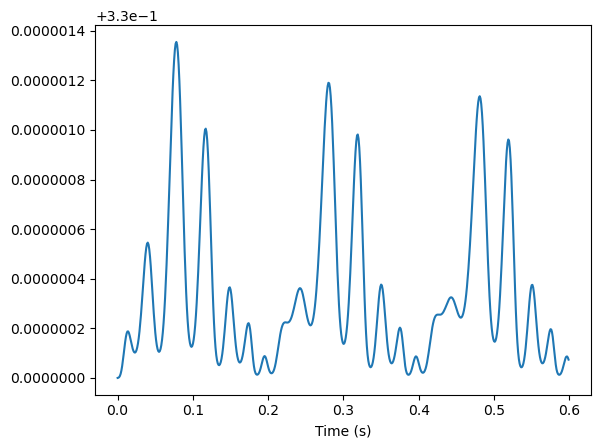

In [100]:
q1  = np.row_stack([R2,theta2,R3,theta3,R4[1,0],theta4,R4[0,0]])
q2i = 0
h   = 0.001
data = []
T    = np.arange(0,0.6,h)

for time in T :

    while True :

        LHS = np.row_stack([Cq(q1),[0,0,0,0,0,0,0,0,1]])
        RHS = np.row_stack([-C(q1),0])

        dq1 = linal.inv(LHS)@RHS
        q1 = q1 + dq1
        if ( np.abs(dq1) < 1e-5 ).all() :
            break

    Cq1 = Cq(q1) 
    Bi1 = Bi(Cq1)

    RHS  = np.row_stack([np.zeros((8,1)),q2i])
    q2   = linal.inv(LHS)@RHS

    Qd1 = Qd(q1,q2)
    G1  = G(Cq1,Qd1) 
    Mi  = Bi1.T@M@Bi1

    q2i_dot = ( linal.inv(Mi)@Bi1.T@Qe(time) - linal.inv(Mi)@Bi1.T@M@G1 )[0,0]
    q2i    = q2i + q2i_dot*h
    q1i    = q1[8,0] + q2i*h
    q1     = np.row_stack([q1[0:8],q1i])

    print(time*100/0.6) 
    data.append(q1i)
    
print(len(data))
plt.plot(T,data)
plt.xlabel('Time (s)')
plt.ticklabel_format(style='plain')

In [28]:
Qev = np.vectorize(Qe)
plt.plot(T,Qev(T))

ValueError: setting an array element with a sequence.